In [1]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [240]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

kx=0.

mu=3
m=.5
t=.2
alR=.7
#B=3.07
#delta=.5
phi=1.

def mut(kx):
    return mu-2*t-kx**2/(2*m)#-alR**2*m/2
def kF(mu):
    return cmath.sqrt(2*m*mu)
def a(t):
    return 1/cmath.sqrt(2*m*t)

def delL(delta):
    return delta*cmath.exp(1j*phi/2)
def delR(delta):
    return delta*cmath.exp(-1j*phi/2)
def nu0(m):
    return m/(2*np.pi)
def xiE(En):
    return kF(mu)/(m*cmath.sqrt(delta**2-En**2))

tL=50
tR=0

NJ=1

gamma=np.pi*nu0(m)*tL**2
#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [155]:
mut(0)

2.6

In [149]:
delta=8

In [150]:
m*tL**2/2/(1+m*tL**2/2/delta)

7.898894154818326

In [151]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
def Hy(alR):
    return -t*t3+1j*alR/2/a(t)*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy(alR))])
        CT=sp.hstack([OT.transpose(),cmm(Hy(alR).conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(mu)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)-kx))))-1j

def gSC1m1(En,kx,delta):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(delta)*tP - np.conj(delL(delta))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,delta):
    return 0*eye4 #-1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(delta)*tP - np.conj(delR(delta))*tM)*\
                  #                               fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4])-1
colindex=np.array([5,6,7,8])-1
hoppings=[tL,tL,-tL,-tL]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+1),4*(NJ+1)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,delta,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,delta),gJm1(En,kx,B))+mHt.toarray()

to optimize by avoiding the computation of gSC1m1 when calling fdetB

In [158]:
M=100
Delarray=np.linspace(0.0001,1,M+1)

In [159]:
PDtr=np.zeros((M+1,NJ))#2*NJ))

En=0

for qq in range(M+1):
    delta=Delarray[qq]
    print(qq)
    ekxB=[]
    def fdetB(B):
        return np.linalg.det(Gtotm1(En,kx,delta,B))/(mu**(4.*(NJ+0)))
    x0roots=np.ndarray.tolist(np.linspace(0,10,12))
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdetB,np.asarray(x0))
        if abs(fdetB(solekx))>10**-6 or solekx<0:
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,4))
        ekxB.extend(solekx)
    ekxB=np.sort(list(set(ekxB)))
    print(ekxB)
    if len(ekxB)<NJ: ###here 2*
        zerocompletion=[0]*(NJ-len(ekxB)) ###here
        ekxB.extend(zerocompletion)
    elif len(ekxB)>NJ:  ###here
        print("Too many roots.")
        break
    PDtr[qq]=np.asarray(ekxB)

0
[544.6418]
1
[544.6343]
2
[544.6305]
3
[544.6303]
4
[544.6337]
5
[544.6406]
6
[544.6511]
7
[544.6651]
8
[544.6826]
9
[544.7035]
10
[544.7279]
11
[544.7556]
12
[544.7866]
13
[544.821]
14
[544.8587]
15
[544.8996]
16
[544.9438]
17
[544.9911]
18
[545.0416]
19
[545.0953]
20
[545.152]
21
[545.2118]
22
[545.2747]
23
[545.3405]
24
[545.4094]
25
[545.4811]
26
[545.5558]
27
[545.6334]
28
[545.7138]
29
[545.797]
30
[545.883]
31
[545.9718]
32
[546.0633]
33
[546.1575]
34
[546.2544]
35
[546.3539]
36
[546.456]
37
[546.5606]
38
[546.6678]
39
[546.7776]
40
[546.8898]
41
[547.0044]
42
[547.1215]
43
[547.2409]
44
[547.3627]
45
[547.4869]
46
[547.6133]
47
[547.742]
48
[547.873]
49
[548.0062]
50
[548.1415]
51
[548.279]
52
[548.4186]
53
[548.5603]
54
[548.7041]
55
[548.8499]
56
[548.9977]
57
[549.1474]
58
[549.2992]
59
[549.4528]
60
[549.6084]
61
[549.7657]
62
[549.925]
63
[550.086]
64
[550.2488]
65
[550.4134]
66
[550.5797]
67
[550.7477]
68
[550.9173]
69
[551.0886]
70
[551.2615]
71
[551.436]
72
[551.612]


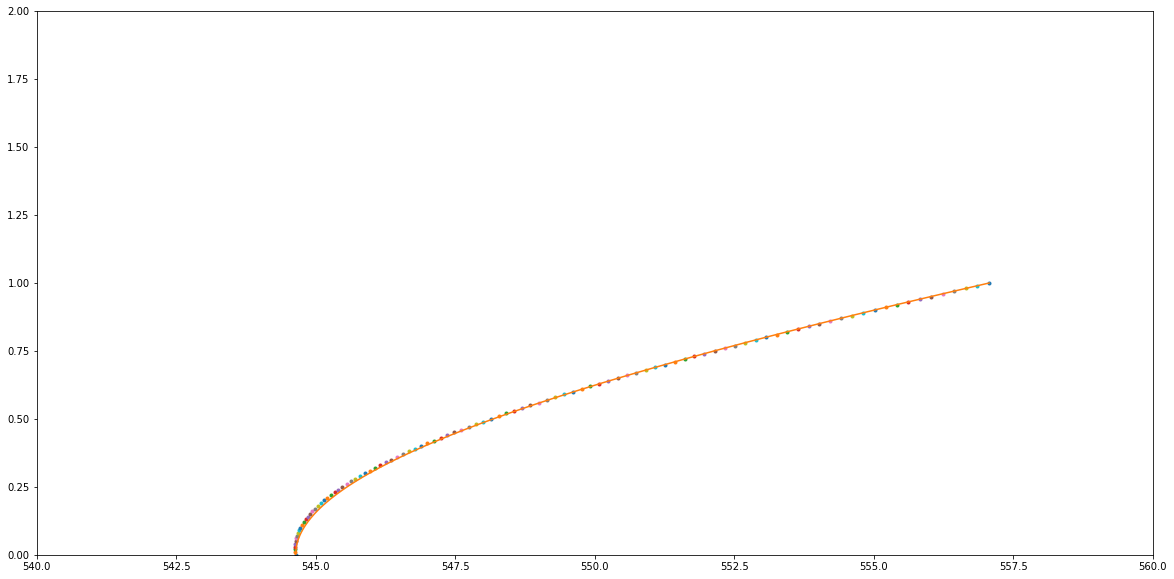

In [239]:
pp.figure(figsize=(20,10))
for p in range(len(PDtr)):
    pp.plot(PDtr[p],[Delarray[p]]*(NJ),'.')
pp.axis([540,560,0,2])
Blist=np.linspace(544.6417,557.0705,1000)
b=900.
n=1/np.sqrt((557.0705-544.6417+np.sqrt(b))**2-b)
pp.plot(Blist,[n*np.sqrt((xc+np.sqrt(b)-544.6417)**2-b) for xc in Blist])

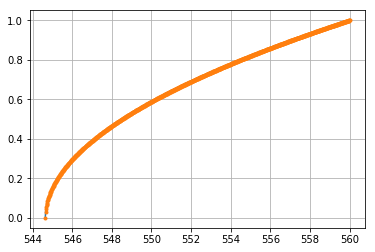

In [211]:
Blist=np.linspace(544.6418,557.0705,1000)
pp.plot(Blist,[1/3.91895*np.sqrt(xc-544.6418) for xc in Blist])
pp.plot(Blist,[1/130.25095*np.sqrt(xc**2-544.6418**2) for xc in Blist],'.')
pp.grid()

In [214]:
np.sqrt(557.0705**2-544.6418**2)

117.0164589406551

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


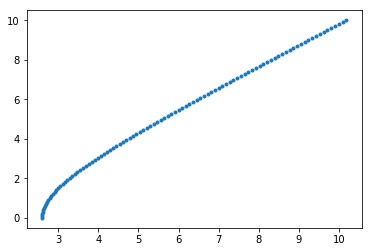

In [241]:
dlist=np.linspace(0,10,100)
Blist=[np.sqrt((gamma/(1+gamma/dlist[r]))**2+mut(0)**2) for r in range(len(dlist))]
pp.plot(Blist,dlist,'.')

In [77]:
MB=100
Blist=np.linspace(0,10,MB+1)
print(Blist)

PDgap=np.ones((len(phiarray),len(Blist)))

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]


In [78]:
Etest=0
LE=101  #E decimation
listEn=np.ndarray.tolist(np.linspace(0,delta,LE))

kmin=-np.pi
kmax=0.1
x0roots=np.linspace(kmin,kmax,10)#np.int((kmax-kmin)/.3))

for qq in range(M+1):
    phi=phiarray[qq]
    print('{}) phi={}'.format(qq,phi))
    
    bind=0
    Bstar=Blist.max()#PDtr[qq,bind]
    for tp in range(MB+1):
        B=Blist[tp]
        print('{}.{}) B={}'.format(qq,tp,B))
        if B<Bstar and Bstar<Blist[tp+1]:
            En=0.
            bind+=1
            if bind<NJ:
                Bstar=PDtr[qq,bind]
            else:
                Bstar=Blist.max()
        else:
            for En in listEn:
                def fdetkx(kxx):
                    return np.linalg.det(Gtotm1(En,kxx,phi,B))/(mu**(8*(NJ+2)))
                for go in range(len(x0roots)):
                    solveEKX=opt.fsolve(fdetkx,[x0roots[go]])
                    if abs(fdetkx(solveEKX))<10**-6:# and abs(solveEKX)<=kF:
                        print("found")
                        Etest=1
                        break
                if Etest==1:
                    break
        print('gap={}'.format(En))
        PDgap[qq,tp]=En
        Etest=0
            

0) phi=0.0
0.0) B=0.0
found
gap=0.285
0.1) B=0.1
found
gap=0.28
0.2) B=0.2
found
gap=0.275
0.3) B=0.3
found
gap=0.27
0.4) B=0.4
found
gap=0.26
0.5) B=0.5
found
gap=0.25
0.6) B=0.6
found
gap=0.235
0.7) B=0.7
found
gap=0.22
0.8) B=0.8
found
gap=0.205
0.9) B=0.9
found
gap=0.195
0.10) B=1.0
found
gap=0.18
0.11) B=1.1
found
gap=0.17
0.12) B=1.2
found
gap=0.16
0.13) B=1.3
found
gap=0.14
0.14) B=1.4
found
gap=0.115
0.15) B=1.5
found
gap=0.09
0.16) B=1.6
found
gap=0.065
0.17) B=1.7
found
gap=0.04
0.18) B=1.8
found
gap=0.015
0.19) B=1.9
found
gap=0.01
0.20) B=2.0
found
gap=0.035
0.21) B=2.1
found
gap=0.055
0.22) B=2.2
found
gap=0.075
0.23) B=2.3
found
gap=0.08
0.24) B=2.4
found
gap=0.075
0.25) B=2.5
found
gap=0.07
0.26) B=2.6
found
gap=0.07
0.27) B=2.7
found
gap=0.065
0.28) B=2.8
found
gap=0.06
0.29) B=2.9
found
gap=0.06
0.30) B=3.0
found
gap=0.055
0.31) B=3.1
found
gap=0.055
0.32) B=3.2
found
gap=0.05
0.33) B=3.3
found
gap=0.05
0.34) B=3.4
found
gap=0.045
0.35) B=3.5
found
gap=0.045
0.36) B=3.

found
gap=0.01
2.96) B=9.6
found
gap=0.01
2.97) B=9.7
found
gap=0.01
2.98) B=9.8
found
gap=0.01
2.99) B=9.9
found
gap=0.01
2.100) B=10.0
found
gap=0.01
3) phi=0.188495559215
3.0) B=0.0
found
gap=0.285
3.1) B=0.1
found
gap=0.28
3.2) B=0.2
found
gap=0.275
3.3) B=0.3
found
gap=0.27
3.4) B=0.4
found
gap=0.26
3.5) B=0.5
found
gap=0.25
3.6) B=0.6
found
gap=0.235
3.7) B=0.7
found
gap=0.22
3.8) B=0.8
found
gap=0.21
3.9) B=0.9
found
gap=0.195
3.10) B=1.0
found
gap=0.18
3.11) B=1.1
found
gap=0.17
3.12) B=1.2
found
gap=0.16
3.13) B=1.3
found
gap=0.135
3.14) B=1.4
found
gap=0.11
3.15) B=1.5
found
gap=0.085
3.16) B=1.6
found
gap=0.06
3.17) B=1.7
found
gap=0.04
3.18) B=1.8
found
gap=0.015
3.19) B=1.9
found
gap=0.015
3.20) B=2.0
found
gap=0.035
3.21) B=2.1
found
gap=0.055
3.22) B=2.2
found
gap=0.08
3.23) B=2.3
found
gap=0.08
3.24) B=2.4
found
gap=0.075
3.25) B=2.5
found
gap=0.07
3.26) B=2.6
found
gap=0.07
3.27) B=2.7
found
gap=0.065
3.28) B=2.8
found
gap=0.06
3.29) B=2.9
found
gap=0.06
3.30) B=3.0
fo

found
gap=0.01
5.90) B=9.0
found
gap=0.015
5.91) B=9.1
found
gap=0.015
5.92) B=9.2
found
gap=0.015
5.93) B=9.3
found
gap=0.01
5.94) B=9.4
found
gap=0.025
5.95) B=9.5
found
gap=0.01
5.96) B=9.6
found
gap=0.01
5.97) B=9.7
found
gap=0.01
5.98) B=9.8
found
gap=0.01
5.99) B=9.9
found
gap=0.01
5.100) B=10.0
found
gap=0.01
6) phi=0.376991118431
6.0) B=0.0
found
gap=0.28
6.1) B=0.1
found
gap=0.28
6.2) B=0.2
found
gap=0.275
6.3) B=0.3
found
gap=0.265
6.4) B=0.4
found
gap=0.26
6.5) B=0.5
found
gap=0.245
6.6) B=0.6
found
gap=0.235
6.7) B=0.7
found
gap=0.22
6.8) B=0.8
found
gap=0.21
6.9) B=0.9
found
gap=0.195
6.10) B=1.0
found
gap=0.18
6.11) B=1.1
found
gap=0.17
6.12) B=1.2
found
gap=0.155
6.13) B=1.3
found
gap=0.13
6.14) B=1.4
found
gap=0.105
6.15) B=1.5
found
gap=0.08
6.16) B=1.6
found
gap=0.055
6.17) B=1.7
found
gap=0.035
6.18) B=1.8
found
gap=0.01
6.19) B=1.9
found
gap=0.02
6.20) B=2.0
found
gap=0.04
6.21) B=2.1
found
gap=0.06
6.22) B=2.2
found
gap=0.08
6.23) B=2.3
found
gap=0.08
6.24) B=2.4
f

found
gap=0.015
8.83) B=8.3
found
gap=0.015
8.84) B=8.4
found
gap=0.015
8.85) B=8.5
found
gap=0.015
8.86) B=8.6
found
gap=0.025
8.87) B=8.7
found
gap=0.015
8.88) B=8.8
found
gap=0.015
8.89) B=8.9
found
gap=0.01
8.90) B=9.0
found
gap=0.015
8.91) B=9.1
found
gap=0.015
8.92) B=9.2
found
gap=0.015
8.93) B=9.3
found
gap=0.01
8.94) B=9.4
found
gap=0.01
8.95) B=9.5
found
gap=0.01
8.96) B=9.6
found
gap=0.01
8.97) B=9.7
found
gap=0.01
8.98) B=9.8
found
gap=0.01
8.99) B=9.9
found
gap=0.01
8.100) B=10.0
found
gap=0.01
9) phi=0.565486677646
9.0) B=0.0
found
gap=0.275
9.1) B=0.1
found
gap=0.275
9.2) B=0.2
found
gap=0.27
9.3) B=0.3
found
gap=0.265
9.4) B=0.4
found
gap=0.255
9.5) B=0.5
found
gap=0.245
9.6) B=0.6
found
gap=0.23
9.7) B=0.7
found
gap=0.22
9.8) B=0.8
found
gap=0.205
9.9) B=0.9
found
gap=0.195
9.10) B=1.0
found
gap=0.18
9.11) B=1.1
found
gap=0.17
9.12) B=1.2
found
gap=0.15
9.13) B=1.3
found
gap=0.12
9.14) B=1.4
found
gap=0.095
9.15) B=1.5
found
gap=0.075
9.16) B=1.6
found
gap=0.05
9.17) B

found
gap=0.02
11.71) B=7.1
found
gap=0.02
11.72) B=7.2
found
gap=0.02
11.73) B=7.3
found
gap=0.015
11.74) B=7.4
found
gap=0.02
11.75) B=7.5
found
gap=0.015
11.76) B=7.6
found
gap=0.015
11.77) B=7.7
found
gap=0.015
11.78) B=7.8
found
gap=0.015
11.79) B=7.9
found
gap=0.015
11.80) B=8.0
found
gap=0.02
11.81) B=8.1
found
gap=0.015
11.82) B=8.2
found
gap=0.015
11.83) B=8.3
found
gap=0.015
11.84) B=8.4
found
gap=0.015
11.85) B=8.5
found
gap=0.015
11.86) B=8.6
found
gap=0.025
11.87) B=8.7
found
gap=0.015
11.88) B=8.8
found
gap=0.015
11.89) B=8.9
found
gap=0.01
11.90) B=9.0
found
gap=0.015
11.91) B=9.1
found
gap=0.015
11.92) B=9.2
found
gap=0.015
11.93) B=9.3
found
gap=0.01
11.94) B=9.4
found
gap=0.01
11.95) B=9.5
found
gap=0.01
11.96) B=9.6
found
gap=0.01
11.97) B=9.7
found
gap=0.01
11.98) B=9.8
found
gap=0.01
11.99) B=9.9
found
gap=0.01
11.100) B=10.0
found
gap=0.01
12) phi=0.753982236862
12.0) B=0.0
found
gap=0.265
12.1) B=0.1
found
gap=0.265
12.2) B=0.2
found
gap=0.265
12.3) B=0.3
found
g

found
gap=0.02
14.54) B=5.4
found
gap=0.03
14.55) B=5.5
found
gap=0.04
14.56) B=5.6
found
gap=0.05
14.57) B=5.7
found
gap=0.055
14.58) B=5.8
found
gap=0.055
14.59) B=5.9
found
gap=0.055
14.60) B=6.0
found
gap=0.055
14.61) B=6.1
found
gap=0.05
14.62) B=6.2
found
gap=0.05
14.63) B=6.3
found
gap=0.05
14.64) B=6.4
found
gap=0.05
14.65) B=6.5
found
gap=0.045
14.66) B=6.6
found
gap=0.045
14.67) B=6.7
found
gap=0.045
14.68) B=6.8
found
gap=0.025
14.69) B=6.9
found
gap=0.02
14.70) B=7.0
found
gap=0.02
14.71) B=7.1
found
gap=0.015
14.72) B=7.2
found
gap=0.015
14.73) B=7.3
found
gap=0.025
14.74) B=7.4
found
gap=0.02
14.75) B=7.5
found
gap=0.015
14.76) B=7.6
found
gap=0.015
14.77) B=7.7
found
gap=0.015
14.78) B=7.8
found
gap=0.015
14.79) B=7.9
found
gap=0.015
14.80) B=8.0
found
gap=0.02
14.81) B=8.1
found
gap=0.015
14.82) B=8.2
found
gap=0.015
14.83) B=8.3
found
gap=0.015
14.84) B=8.4
found
gap=0.015
14.85) B=8.5
found
gap=0.015
14.86) B=8.6
found
gap=0.025
14.87) B=8.7
found
gap=0.015
14.88) B=8

found
gap=0.045
17.37) B=3.7
found
gap=0.04
17.38) B=3.8
found
gap=0.04
17.39) B=3.9
found
gap=0.04
17.40) B=4.0
found
gap=0.035
17.41) B=4.1
found
gap=0.035
17.42) B=4.2
found
gap=0.035
17.43) B=4.3
found
gap=0.045
17.44) B=4.4
found
gap=0.035
17.45) B=4.5
found
gap=0.04
17.46) B=4.6
found
gap=0.05
17.47) B=4.7
found
gap=0.03
17.48) B=4.8
found
gap=0.04
17.49) B=4.9
found
gap=0.03
17.50) B=5.0
found
gap=0.025
17.51) B=5.1
found
gap=0.015
17.52) B=5.2
found
gap=0.0
17.53) B=5.3
found
gap=0.015
17.54) B=5.4
found
gap=0.025
17.55) B=5.5
found
gap=0.04
17.56) B=5.6
found
gap=0.05
17.57) B=5.7
found
gap=0.055
17.58) B=5.8
found
gap=0.055
17.59) B=5.9
found
gap=0.055
17.60) B=6.0
found
gap=0.055
17.61) B=6.1
found
gap=0.05
17.62) B=6.2
found
gap=0.05
17.63) B=6.3
found
gap=0.05
17.64) B=6.4
found
gap=0.05
17.65) B=6.5
found
gap=0.045
17.66) B=6.6
found
gap=0.02
17.67) B=6.7
found
gap=0.045
17.68) B=6.8
found
gap=0.02
17.69) B=6.9
found
gap=0.02
17.70) B=7.0
found
gap=0.02
17.71) B=7.1
found

found
gap=0.085
20.21) B=2.1
found
gap=0.08
20.22) B=2.2
found
gap=0.08
20.23) B=2.3
found
gap=0.075
20.24) B=2.4
found
gap=0.07
20.25) B=2.5
found
gap=0.065
20.26) B=2.6
found
gap=0.065
20.27) B=2.7
found
gap=0.06
20.28) B=2.8
found
gap=0.06
20.29) B=2.9
found
gap=0.055
20.30) B=3.0
found
gap=0.055
20.31) B=3.1
found
gap=0.05
20.32) B=3.2
found
gap=0.05
20.33) B=3.3
found
gap=0.045
20.34) B=3.4
found
gap=0.045
20.35) B=3.5
found
gap=0.045
20.36) B=3.6
found
gap=0.04
20.37) B=3.7
found
gap=0.04
20.38) B=3.8
found
gap=0.04
20.39) B=3.9
found
gap=0.035
20.40) B=4.0
found
gap=0.035
20.41) B=4.1
found
gap=0.035
20.42) B=4.2
found
gap=0.045
20.43) B=4.3
found
gap=0.03
20.44) B=4.4
found
gap=0.03
20.45) B=4.5
found
gap=0.03
20.46) B=4.6
found
gap=0.035
20.47) B=4.7
found
gap=0.03
20.48) B=4.8
found
gap=0.04
20.49) B=4.9
found
gap=0.035
20.50) B=5.0
found
gap=0.025
20.51) B=5.1
found
gap=0.02
20.52) B=5.2
found
gap=0.005
20.53) B=5.3
found
gap=0.01
20.54) B=5.4
found
gap=0.025
20.55) B=5.5
fo

found
gap=0.215
23.4) B=0.4
found
gap=0.21
23.5) B=0.5
found
gap=0.2
23.6) B=0.6
found
gap=0.19
23.7) B=0.7
found
gap=0.18
23.8) B=0.8
found
gap=0.17
23.9) B=0.9
found
gap=0.145
23.10) B=1.0
found
gap=0.12
23.11) B=1.1
found
gap=0.095
23.12) B=1.2
found
gap=0.075
23.13) B=1.3
found
gap=0.05
23.14) B=1.4
found
gap=0.025
23.15) B=1.5
found
gap=0.0
23.16) B=1.6
found
gap=0.02
23.17) B=1.7
found
gap=0.045
23.18) B=1.8
found
gap=0.065
23.19) B=1.9
found
gap=0.085
23.20) B=2.0
found
gap=0.085
23.21) B=2.1
found
gap=0.08
23.22) B=2.2
found
gap=0.075
23.23) B=2.3
found
gap=0.07
23.24) B=2.4
found
gap=0.065
23.25) B=2.5
found
gap=0.065
23.26) B=2.6
found
gap=0.06
23.27) B=2.7
found
gap=0.06
23.28) B=2.8
found
gap=0.055
23.29) B=2.9
found
gap=0.055
23.30) B=3.0
found
gap=0.05
23.31) B=3.1
found
gap=0.05
23.32) B=3.2
found
gap=0.045
23.33) B=3.3
found
gap=0.045
23.34) B=3.4
found
gap=0.045
23.35) B=3.5
found
gap=0.04
23.36) B=3.6
found
gap=0.04
23.37) B=3.7
found
gap=0.04
23.38) B=3.8
found
gap=0

found
gap=0.01
25.89) B=8.9
found
gap=0.015
25.90) B=9.0
found
gap=0.01
25.91) B=9.1
found
gap=0.01
25.92) B=9.2
found
gap=0.01
25.93) B=9.3
found
gap=0.01
25.94) B=9.4
found
gap=0.01
25.95) B=9.5
found
gap=0.01
25.96) B=9.6
found
gap=0.01
25.97) B=9.7
found
gap=0.01
25.98) B=9.8
found
gap=0.01
25.99) B=9.9
found
gap=0.01
25.100) B=10.0
found
gap=0.01
26) phi=1.63362817987
26.0) B=0.0
found
gap=0.205
26.1) B=0.1
found
gap=0.205
26.2) B=0.2
found
gap=0.205
26.3) B=0.3
found
gap=0.2
26.4) B=0.4
found
gap=0.195
26.5) B=0.5
found
gap=0.185
26.6) B=0.6
found
gap=0.18
26.7) B=0.7
found
gap=0.17
26.8) B=0.8
found
gap=0.145
26.9) B=0.9
found
gap=0.125
26.10) B=1.0
found
gap=0.1
26.11) B=1.1
found
gap=0.075
26.12) B=1.2
found
gap=0.055
26.13) B=1.3
found
gap=0.03
26.14) B=1.4
found
gap=0.01
26.15) B=1.5
found
gap=0.015
26.16) B=1.6
found
gap=0.04
26.17) B=1.7
found
gap=0.06
26.18) B=1.8
found
gap=0.08
26.19) B=1.9
found
gap=0.085
26.20) B=2.0
found
gap=0.08
26.21) B=2.1
found
gap=0.075
26.22) B

found
gap=0.015
28.73) B=7.3
found
gap=0.025
28.74) B=7.4
found
gap=0.02
28.75) B=7.5
found
gap=0.025
28.76) B=7.6
found
gap=0.015
28.77) B=7.7
found
gap=0.025
28.78) B=7.8
found
gap=0.015
28.79) B=7.9
found
gap=0.015
28.80) B=8.0
found
gap=0.015
28.81) B=8.1
found
gap=0.02
28.82) B=8.2
found
gap=0.025
28.83) B=8.3
found
gap=0.01
28.84) B=8.4
found
gap=0.01
28.85) B=8.5
found
gap=0.015
28.86) B=8.6
found
gap=0.015
28.87) B=8.7
found
gap=0.01
28.88) B=8.8
found
gap=0.01
28.89) B=8.9
found
gap=0.01
28.90) B=9.0
found
gap=0.01
28.91) B=9.1
found
gap=0.015
28.92) B=9.2
found
gap=0.015
28.93) B=9.3
found
gap=0.01
28.94) B=9.4
found
gap=0.01
28.95) B=9.5
found
gap=0.01
28.96) B=9.6
found
gap=0.01
28.97) B=9.7
found
gap=0.01
28.98) B=9.8
found
gap=0.01
28.99) B=9.9
found
gap=0.01
28.100) B=10.0
found
gap=0.01
29) phi=1.82212373908
29.0) B=0.0
found
gap=0.185
29.1) B=0.1
found
gap=0.19
29.2) B=0.2
found
gap=0.185
29.3) B=0.3
found
gap=0.185
29.4) B=0.4
found
gap=0.18
29.5) B=0.5
found
gap=0.17

found
gap=0.025
31.57) B=5.7
found
gap=0.045
31.58) B=5.8
found
gap=0.05
31.59) B=5.9
found
gap=0.045
31.60) B=6.0
found
gap=0.045
31.61) B=6.1
found
gap=0.045
31.62) B=6.2
found
gap=0.045
31.63) B=6.3
found
gap=0.04
31.64) B=6.4
found
gap=0.04
31.65) B=6.5
found
gap=0.04
31.66) B=6.6
found
gap=0.04
31.67) B=6.7
found
gap=0.04
31.68) B=6.8
found
gap=0.015
31.69) B=6.9
found
gap=0.025
31.70) B=7.0
found
gap=0.025
31.71) B=7.1
found
gap=0.02
31.72) B=7.2
found
gap=0.035
31.73) B=7.3
found
gap=0.015
31.74) B=7.4
found
gap=0.015
31.75) B=7.5
found
gap=0.015
31.76) B=7.6
found
gap=0.015
31.77) B=7.7
found
gap=0.025
31.78) B=7.8
found
gap=0.015
31.79) B=7.9
found
gap=0.01
31.80) B=8.0
found
gap=0.01
31.81) B=8.1
found
gap=0.01
31.82) B=8.2
found
gap=0.01
31.83) B=8.3
found
gap=0.01
31.84) B=8.4
found
gap=0.01
31.85) B=8.5
found
gap=0.01
31.86) B=8.6
found
gap=0.01
31.87) B=8.7
found
gap=0.01
31.88) B=8.8
found
gap=0.005
31.89) B=8.9
found
gap=0.015
31.90) B=9.0
found
gap=0.01
31.91) B=9.1
fo

found
gap=0.025
34.41) B=4.1
found
gap=0.025
34.42) B=4.2
found
gap=0.03
34.43) B=4.3
found
gap=0.025
34.44) B=4.4
found
gap=0.025
34.45) B=4.5
found
gap=0.035
34.46) B=4.6
found
gap=0.025
34.47) B=4.7
found
gap=0.02
34.48) B=4.8
found
gap=0.02
34.49) B=4.9
found
gap=0.03
34.50) B=5.0
found
gap=0.05
34.51) B=5.1
found
gap=0.02
34.52) B=5.2
found
gap=0.025
34.53) B=5.3
found
gap=0.01
34.54) B=5.4
found
gap=0.005
34.55) B=5.5
found
gap=0.015
34.56) B=5.6
found
gap=0.03
34.57) B=5.7
found
gap=0.04
34.58) B=5.8
found
gap=0.045
34.59) B=5.9
found
gap=0.045
34.60) B=6.0
found
gap=0.045
34.61) B=6.1
found
gap=0.04
34.62) B=6.2
found
gap=0.04
34.63) B=6.3
found
gap=0.04
34.64) B=6.4
found
gap=0.04
34.65) B=6.5
found
gap=0.04
34.66) B=6.6
found
gap=0.03
34.67) B=6.7
found
gap=0.035
34.68) B=6.8
found
gap=0.03
34.69) B=6.9
found
gap=0.025
34.70) B=7.0
found
gap=0.025
34.71) B=7.1
found
gap=0.015
34.72) B=7.2
found
gap=0.03
34.73) B=7.3
found
gap=0.015
34.74) B=7.4
found
gap=0.015
34.75) B=7.5
fo

found
gap=0.045
37.26) B=2.6
found
gap=0.04
37.27) B=2.7
found
gap=0.04
37.28) B=2.8
found
gap=0.04
37.29) B=2.9
found
gap=0.035
37.30) B=3.0
found
gap=0.035
37.31) B=3.1
found
gap=0.035
37.32) B=3.2
found
gap=0.03
37.33) B=3.3
found
gap=0.03
37.34) B=3.4
found
gap=0.03
37.35) B=3.5
found
gap=0.03
37.36) B=3.6
found
gap=0.03
37.37) B=3.7
found
gap=0.025
37.38) B=3.8
found
gap=0.025
37.39) B=3.9
found
gap=0.025
37.40) B=4.0
found
gap=0.025
37.41) B=4.1
found
gap=0.025
37.42) B=4.2
found
gap=0.025
37.43) B=4.3
found
gap=0.02
37.44) B=4.4
found
gap=0.025
37.45) B=4.5
found
gap=0.025
37.46) B=4.6
found
gap=0.02
37.47) B=4.7
found
gap=0.04
37.48) B=4.8
found
gap=0.02
37.49) B=4.9
found
gap=0.03
37.50) B=5.0
found
gap=0.02
37.51) B=5.1
found
gap=0.03
37.52) B=5.2
found
gap=0.025
37.53) B=5.3
found
gap=0.015
37.54) B=5.4
found
gap=0.0
37.55) B=5.5
found
gap=0.015
37.56) B=5.6
found
gap=0.025
37.57) B=5.7
found
gap=0.04
37.58) B=5.8
found
gap=0.04
37.59) B=5.9
found
gap=0.04
37.60) B=6.0
found

found
gap=0.02
40.11) B=1.1
found
gap=0.0
40.12) B=1.2
found
gap=0.025
40.13) B=1.3
found
gap=0.045
40.14) B=1.4
found
gap=0.06
40.15) B=1.5
found
gap=0.06
40.16) B=1.6
found
gap=0.06
40.17) B=1.7
found
gap=0.055
40.18) B=1.8
found
gap=0.055
40.19) B=1.9
found
gap=0.05
40.20) B=2.0
found
gap=0.05
40.21) B=2.1
found
gap=0.045
40.22) B=2.2
found
gap=0.045
40.23) B=2.3
found
gap=0.04
40.24) B=2.4
found
gap=0.04
40.25) B=2.5
found
gap=0.04
40.26) B=2.6
found
gap=0.035
40.27) B=2.7
found
gap=0.035
40.28) B=2.8
found
gap=0.035
40.29) B=2.9
found
gap=0.03
40.30) B=3.0
found
gap=0.03
40.31) B=3.1
found
gap=0.03
40.32) B=3.2
found
gap=0.03
40.33) B=3.3
found
gap=0.03
40.34) B=3.4
found
gap=0.025
40.35) B=3.5
found
gap=0.025
40.36) B=3.6
found
gap=0.025
40.37) B=3.7
found
gap=0.025
40.38) B=3.8
found
gap=0.025
40.39) B=3.9
found
gap=0.025
40.40) B=4.0
found
gap=0.02
40.41) B=4.1
found
gap=0.02
40.42) B=4.2
found
gap=0.02
40.43) B=4.3
found
gap=0.025
40.44) B=4.4
found
gap=0.02
40.45) B=4.5
found

found
gap=0.01
42.97) B=9.7
found
gap=0.01
42.98) B=9.8
found
gap=0.005
42.99) B=9.9
found
gap=0.005
42.100) B=10.0
found
gap=0.005
43) phi=2.70176968209
43.0) B=0.0
found
gap=0.08
43.1) B=0.1
found
gap=0.08
43.2) B=0.2
found
gap=0.08
43.3) B=0.3
found
gap=0.08
43.4) B=0.4
found
gap=0.08
43.5) B=0.5
found
gap=0.08
43.6) B=0.6
found
gap=0.075
43.7) B=0.7
found
gap=0.075
43.8) B=0.8
found
gap=0.05
43.9) B=0.9
found
gap=0.03
43.10) B=1.0
found
gap=0.005
43.11) B=1.1
found
gap=0.015
43.12) B=1.2
found
gap=0.035
43.13) B=1.3
found
gap=0.05
43.14) B=1.4
found
gap=0.055
43.15) B=1.5
found
gap=0.05
43.16) B=1.6
found
gap=0.05
43.17) B=1.7
found
gap=0.045
43.18) B=1.8
found
gap=0.045
43.19) B=1.9
found
gap=0.04
43.20) B=2.0
found
gap=0.04
43.21) B=2.1
found
gap=0.04
43.22) B=2.2
found
gap=0.035
43.23) B=2.3
found
gap=0.035
43.24) B=2.4
found
gap=0.035
43.25) B=2.5
found
gap=0.03
43.26) B=2.6
found
gap=0.03
43.27) B=2.7
found
gap=0.03
43.28) B=2.8
found
gap=0.03
43.29) B=2.9
found
gap=0.025
43.3

found
gap=0.02
45.81) B=8.1
found
gap=0.01
45.82) B=8.2
found
gap=0.01
45.83) B=8.3
found
gap=0.02
45.84) B=8.4
found
gap=0.01
45.85) B=8.5
found
gap=0.02
45.86) B=8.6
found
gap=0.01
45.87) B=8.7
found
gap=0.005
45.88) B=8.8
found
gap=0.0
45.89) B=8.9
found
gap=0.005
45.90) B=9.0
found
gap=0.005
45.91) B=9.1
found
gap=0.01
45.92) B=9.2
found
gap=0.005
45.93) B=9.3
found
gap=0.005
45.94) B=9.4
found
gap=0.01
45.95) B=9.5
found
gap=0.005
45.96) B=9.6
found
gap=0.01
45.97) B=9.7
found
gap=0.005
45.98) B=9.8
found
gap=0.005
45.99) B=9.9
found
gap=0.005
45.100) B=10.0
found
gap=0.005
46) phi=2.8902652413
46.0) B=0.0
found
gap=0.055
46.1) B=0.1
found
gap=0.055
46.2) B=0.2
found
gap=0.055
46.3) B=0.3
found
gap=0.055
46.4) B=0.4
found
gap=0.055
46.5) B=0.5
found
gap=0.055
46.6) B=0.6
found
gap=0.055
46.7) B=0.7
found
gap=0.055
46.8) B=0.8
found
gap=0.045
46.9) B=0.9
found
gap=0.02
46.10) B=1.0
found
gap=0.0
46.11) B=1.1
found
gap=0.02
46.12) B=1.2
found
gap=0.035
46.13) B=1.3
found
gap=0.045
4

found
gap=0.025
48.64) B=6.4
found
gap=0.025
48.65) B=6.5
found
gap=0.025
48.66) B=6.6
found
gap=0.01
48.67) B=6.7
found
gap=0.02
48.68) B=6.8
found
gap=0.01
48.69) B=6.9
found
gap=0.01
48.70) B=7.0
found
gap=0.01
48.71) B=7.1
found
gap=0.02
48.72) B=7.2
found
gap=0.01
48.73) B=7.3
found
gap=0.02
48.74) B=7.4
found
gap=0.005
48.75) B=7.5
found
gap=0.005
48.76) B=7.6
found
gap=0.005
48.77) B=7.7
found
gap=0.005
48.78) B=7.8
found
gap=0.005
48.79) B=7.9
found
gap=0.005
48.80) B=8.0
found
gap=0.005
48.81) B=8.1
found
gap=0.01
48.82) B=8.2
found
gap=0.005
48.83) B=8.3
found
gap=0.01
48.84) B=8.4
found
gap=0.005
48.85) B=8.5
found
gap=0.02
48.86) B=8.6
found
gap=0.005
48.87) B=8.7
found
gap=0.005
48.88) B=8.8
found
gap=0.005
48.89) B=8.9
found
gap=0.005
48.90) B=9.0
found
gap=0.005
48.91) B=9.1
found
gap=0.005
48.92) B=9.2
found
gap=0.005
48.93) B=9.3
found
gap=0.005
48.94) B=9.4
found
gap=0.005
48.95) B=9.5
found
gap=0.005
48.96) B=9.6
found
gap=0.005
48.97) B=9.7
found
gap=0.005
48.98) B=

In [82]:
0.085/0.5

0.17

PDgap4=PDgap

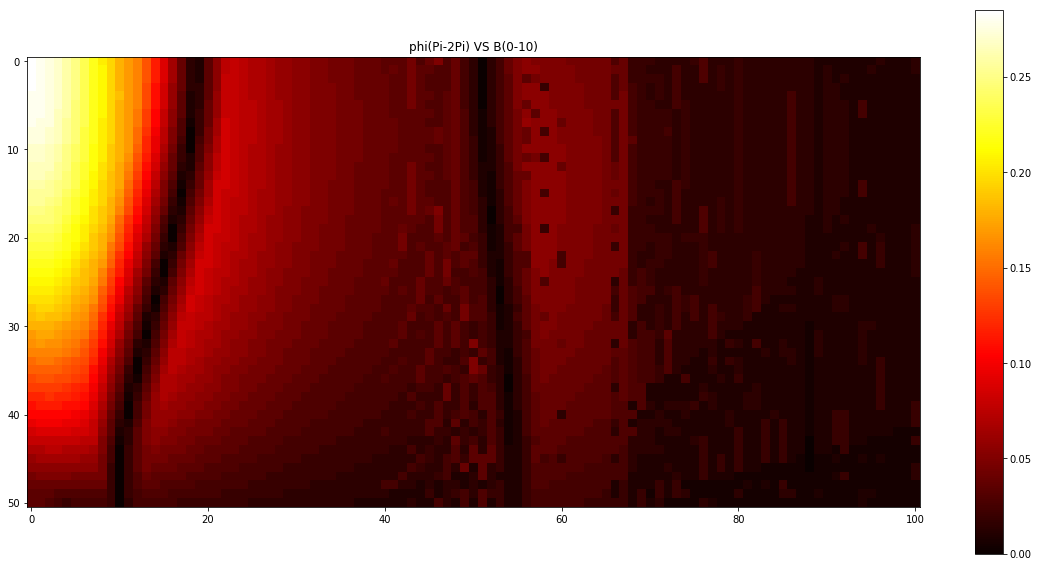

In [81]:
pp.figure(figsize=(20,10))
pp.title('phi(Pi-2Pi) VS B(0-10)')
pp.imshow(PDgap4,cmap='hot')
pp.colorbar()

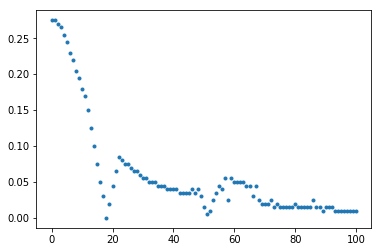

In [88]:
pp.plot(range(len(PDgap4[8])),PDgap4[8],'.')

PDgap3=PDgap

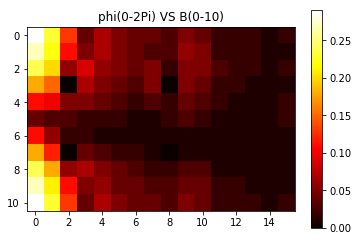

In [71]:
pp.title('phi(0-2Pi) VS B(0-10)')
pp.imshow(PDgap3,cmap='hot')
pp.colorbar()

PDgap2=PDgap

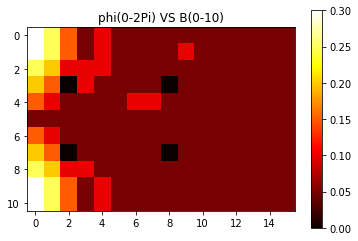

In [68]:
pp.title('phi(0-2Pi) VS B(0-10)')
pp.imshow(PDgap2,cmap='hot')
pp.colorbar()

not PDgap1=PDgap

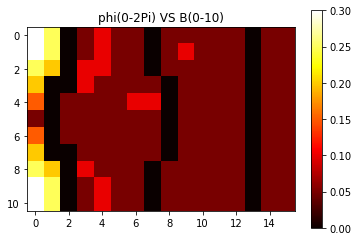

In [65]:
pp.title('phi(0-2Pi) VS B(0-10)')
pp.imshow(PDgap,cmap='hot')
pp.colorbar()